## EDA
We performed a short EDA on our data.

#### Imports:

In [1]:
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

#### Functions:

In [2]:
def visualize_data(features,real_labels,mode,title):
    if mode == "pca":
        pca = PCA(n_components=2)
        pca.fit(features)
        tt = pca.transform(features)
    elif mode == "tsne":
        tt = TSNE(n_components=2).fit_transform(features)
    else:
        raise NameError('Unkown visualization mode')
        
    df = pd.DataFrame(tt,index=real_labels.index)
    df["score"] = real_labels

    fig, ax = plt.subplots()
    ax.set_title(title, fontsize = 18)
    fig.set_size_inches(h=10,w=15)
    
    color_list = ['red','blue','green','magenta','black','brown','gray','yellow']
    colors = dict(zip(real_labels.unique(),color_list[:len(real_labels.unique())]))

    grouped = df.groupby('score')
    for key, group in grouped:
        group.plot(ax=ax,kind='scatter', x=0, y=1, label=key, color=colors[key])

    plt.show()

#### Read Data:

In [3]:
final_matches_db = pd.read_csv("databases/my_matches_db.csv", encoding='latin-1', index_col = [0])

#### All Features:

In [4]:
#Availible Leagues:
#"England_Premier_League","France_Ligue_1","Germany_1._Bundesliga","Netherlands_Eredivisie","Spain_LIGA_BBVA"

current_leagues = ["England_Premier_League","France_Ligue_1","Germany_1._Bundesliga","Netherlands_Eredivisie","Spain_LIGA_BBVA"]

#Not Availible Leagues (yet):
#Italy_Serie_A/Switzerland_Super_League

In [5]:
window_size = 5
basic_info       = ["index","league","season","stage","home_team_name","away_team_name","score"]
betting_odds     = ["B365H","WHH","VCH","B365A","WHA","VCA","B365D","WHD","VCD"]
last_games_wld   = [str(x)+"_last_wld" for x in list(range(1,window_size))]
window_features  = [str(x)+"_pos_goals" for x in list(range(2,window_size))]+[str(x)+"_neg_goals" for x in list(range(2,window_size))]+[str(x)+"_wins" for x in list(range(2,window_size))]+[str(x)+"_loses" for x in list(range(2,window_size))]
new_features     = ["points","norm_points","position","straight_wins","straight_loses","straight_draws","tot_pos_goals","tot_neg_goals","goals_diff"] + window_features# + last_games_wld
important_info   = basic_info + ["home_team_goal","away_team_goal"]

percent_per_season_columns = ["home_win_season_percent","home_lose_season_percent","away_win_season_percent","away_lose_season_percent"]
percent_total_columns      = ["home_win_percent","home_lose_percent","away_win_percent","away_lose_percent"]

home_away        = ["home","away"]

new_columns      = important_info + betting_odds

new_new_columns = []

for r in itertools.product(home_away,new_features): new_new_columns.append(r[0] +"_"+ r[1])
    
features_list = new_new_columns + percent_per_season_columns + percent_total_columns + betting_odds# + ["stage"]
labels_list   = "win_lose_draw"

#### Visualization:

1) Check if we have nulls in our data:

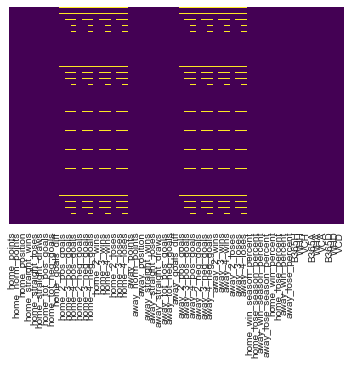

In [6]:
sns.heatmap(final_matches_db[features_list].isnull(),yticklabels=False,cbar=False,cmap='viridis')

Remove all nulls:

In [7]:
final_matches_db.dropna(axis = 0,inplace=True)

2) First of all we will visualize our data using TSNE:

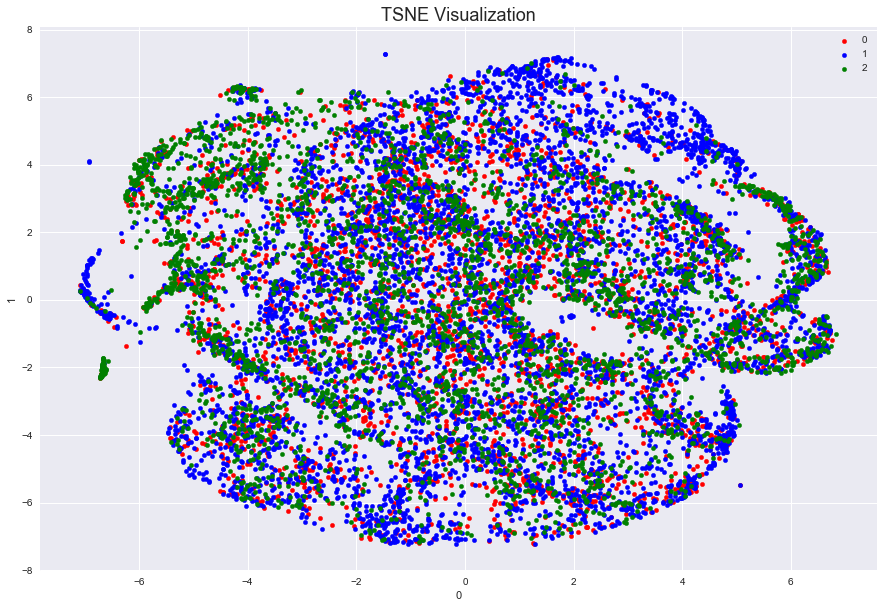

In [8]:
visualize_data(final_matches_db[features_list],final_matches_db[labels_list],"tsne","TSNE Visualization")

We can see that our data is not so simple and it all mixed up. We deal here with a complex problem.
<br><br>
This will be a great challenge to predict the score.

3) Next thing we wanted to see is if our data is balanced:

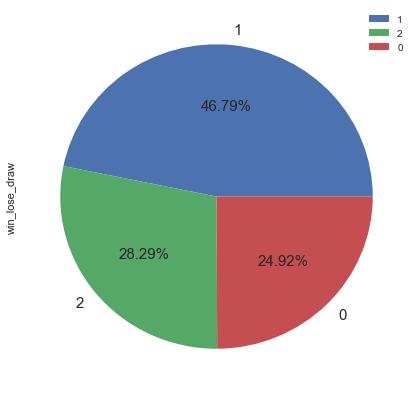

In [9]:
final_matches_db["win_lose_draw"].value_counts().plot.pie(figsize=(7, 7),legend=True,autopct='%.2f%%',fontsize=15)

We can see that our data is not balanced. It seems that much more matches ends with win of the home team.
We handled this issue with two other startegies:
- In the beggining we wanted to maintain the realistic ratio because we wanted our model to take it under considaration that home team has higher probabilty to win. This strategy cuased our models to predict "draw" in rare cases. We tried to add threshold in order to force "draw" decisions but the performance were not so good.
- The second strategy was to drop/duplicate samles in order to achieve a balanced dataset. We saw that since we acted that way our models predicted much more from class "draw" and got better performance. NOTE that we added features that take the home adventage under consideration instead.

4) Than we wanted to see waht is the correlation between all bookies. We expected to see very high correlative betting odds:

In [10]:
all_betting_odds         = final_matches_db[["B365H","WHH","VCH","B365A","WHA","VCA","B365D","WHD","VCD"]].dropna()
all_betting_odds_corrmat = all_betting_odds.corr()

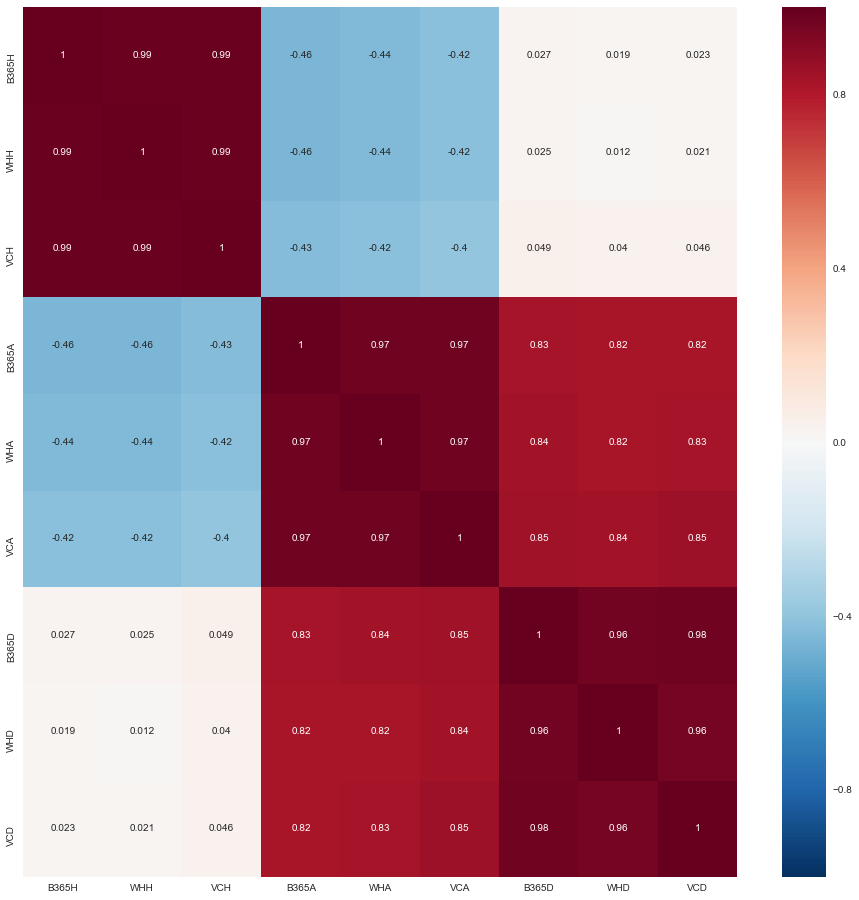

In [11]:
fig, ax1 = plt.subplots(figsize = (16, 16), ncols = 1, sharey = True)
sns.heatmap(all_betting_odds_corrmat, vmax = 1, annot = True)

We can see that our expectations were true and it means that we have some very correlative features. We will take it under considaration and maybe drop some of them in order to avoid "The curse of dimensionality".

5) Last thing we wanted to see is if its true that "each league has its own rules". This was important to us beacuse in order to increase our dataset size we decided to take data from some leagues instead of one. If each league act differently we have a little problem.

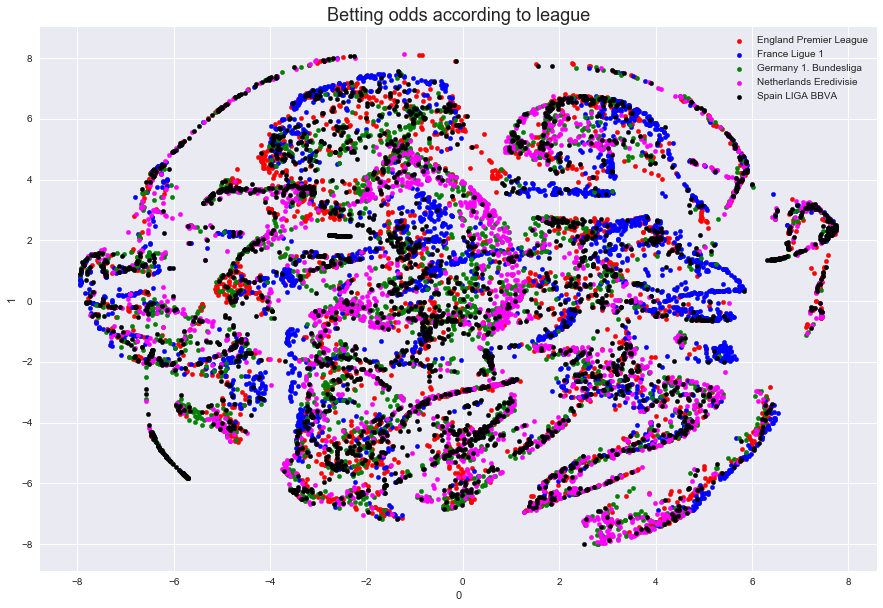

In [12]:
visualize_data(final_matches_db[betting_odds],final_matches_db["league"],"tsne","Betting odds according to league")

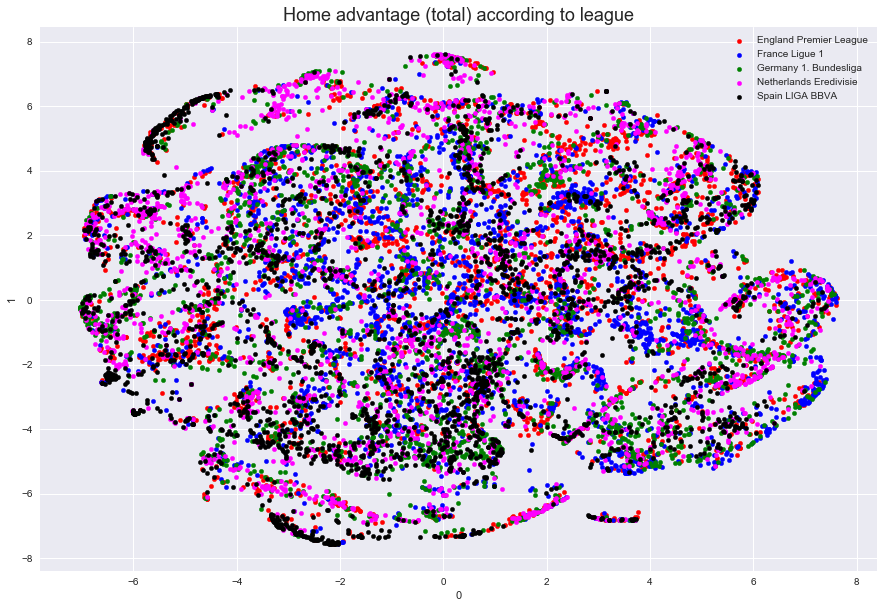

In [13]:
visualize_data(final_matches_db[percent_total_columns],final_matches_db["league"],"tsne","Home advantage (total) according to league")

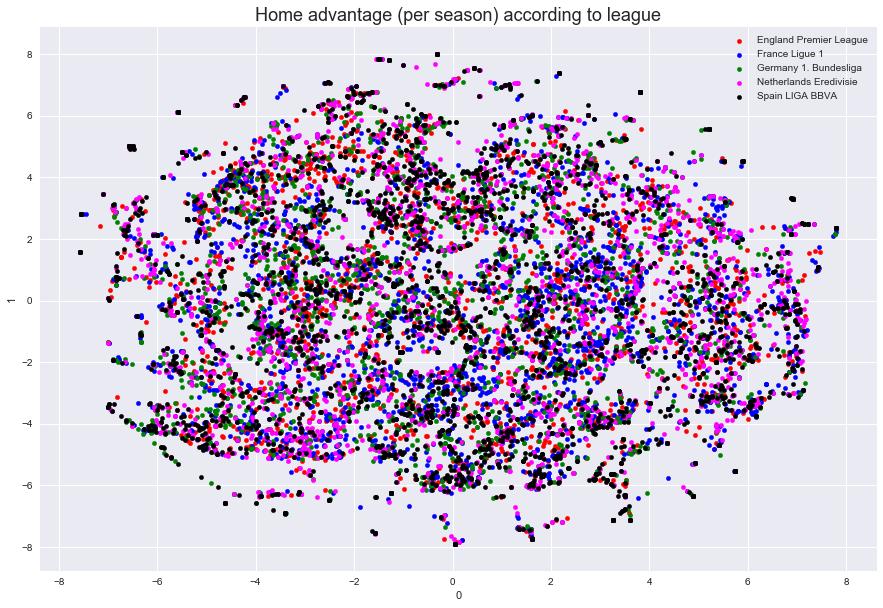

In [14]:
visualize_data(final_matches_db[percent_per_season_columns],final_matches_db["league"],"tsne","Home advantage (per season) according to league")

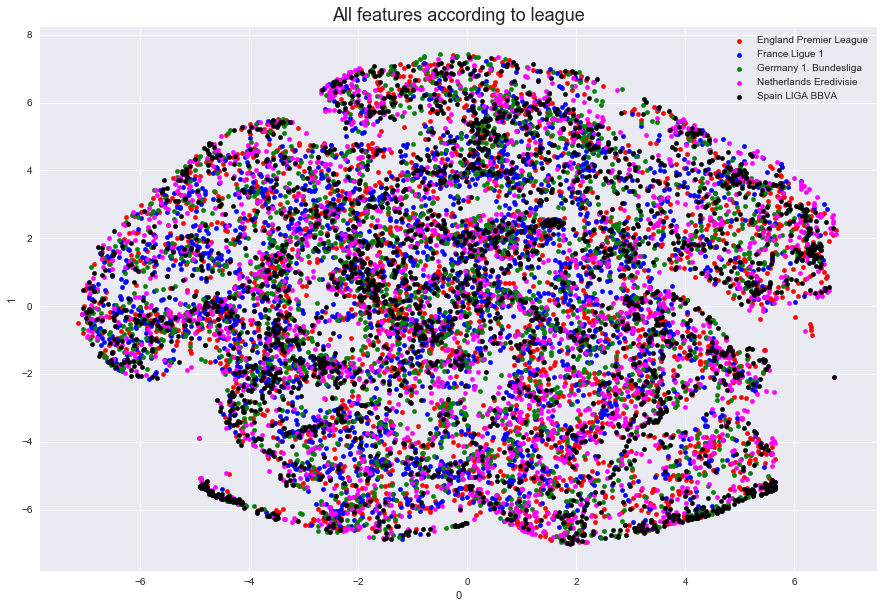

In [15]:
visualize_data(final_matches_db[new_new_columns],final_matches_db["league"],"tsne","All features according to league")

We can see that all leagues are mixed up. This is a good sign for us.